In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import scqubits as scq
from scqubits import HilbertSpace, InteractionTerm, ParameterSweep

import numpy as np

np.set_printoptions(threshold=10, edgeitems=2)

# Define HilbertSpace object: two transmons coupled to an oscillator


tmon1 = scq.TunableTransmon(
    EJmax=40.0,
    EC=0.2,
    d=0.1,
    flux=0.23,
    ng=0.3,
    ncut=40,
    truncated_dim=3,     # after diagonalization, we will keep 3 levels
    id_str="tmon1"       # optional, used for referencing from within
                         # ParameterSweep or HilbertSpace
)

tmon2 = scq.TunableTransmon(
    EJmax=15.0,
    EC=0.15,
    d=0.2,
    flux=0.0,
    ng=0.0,
    ncut=30,
    truncated_dim=3,
    id_str="tmon2"
)

resonator = scq.Oscillator(
    E_osc=4.5,
    truncated_dim=4    # up to 3 photons (0,1,2,3)
)

hilbertspace = scq.HilbertSpace([tmon1, tmon2, resonator])


g1 = 0.1  # coupling resonator-CPB1 (without charge matrix elements)
g2 = 0.2  # coupling resonator-CPB2 (without charge matrix elements)

hilbertspace.add_interaction(
    g_strength = g1,
    op1 = tmon1.n_operator,
    op2 = resonator.creation_operator,
    add_hc = True,
    id_str="tmon1-resonator"  # optional keyword argument
)

hilbertspace.add_interaction(
    g_strength = g2,
    op1 = tmon2.n_operator,
    op2 = resonator.creation_operator,
    add_hc = True,
    id_str="tmon2-resonator"  # optional keyword argument
)

# Set up parameter name and values
pname1 = 'flux'  
flux_vals = np.linspace(0.0, 2.0, 171)
pname2 = 'ng'
ng_vals = np.linspace(-0.5, 0.5, 49)

# combine into a dictionary
paramvals_by_name = {pname1: flux_vals, pname2: ng_vals}


area_ratio = 1.2

def update_hilbertspace(flux, ng):  # function that defines how Hilbert space components are updated
    tmon1.flux = flux
    tmon2.flux = area_ratio * flux
    tmon2.ng = ng

# dictionary with information on which subsystems are affected by changing parameters    
subsys_update_info = {pname1: [tmon1, tmon2],
                      pname2: [tmon2]}

    
# create the ParameterSweep    
sweep = ParameterSweep(
    hilbertspace=hilbertspace,
    paramvals_by_name=paramvals_by_name,
    update_hilbertspace=update_hilbertspace,
    evals_count=20,
    subsys_update_info=subsys_update_info,
    num_cpus=4
)

Parallel compute bare eigensys for subsystem tmon1 [num_cpus=4]

Parallel compute bare eigensys for subsystem tmon2 [num_cpus=4]

Parallel compute bare eigensys for subsystem Oscillator_1 [num_cpus=4]

Parallel compute dressed eigensys [num_cpus=4]

## Dispersive regime

Coupled systems of qubits and harmonic modes are frequently operated in the **dispersive regime** where relevant transition frequencies are detuned from each other and hybridization among levels can be treated perturbatively. 
An effective description of this dispersive regime involves energy corrections and dispersive couplings phrased in terms of 

* **Lamb shifts**, 
* **ac Stark shifts**, and 
* **Kerr terms**, 

to leading order. scqubits computes the associated coefficients as part of `ParameterSweep` and makes them accessible through 

* `"lamb"`:  `NamedSlotsNdarray` with axes `"subsys", <parameters>, <state label l>`
* `"chi"`:   `NamedSlotsNdarray` with axes `"subsys1", "subsys2", <parameters>, <state label l>`
* `"kerr"`:  `NamedSlotsNdarray` with axes `"subsys1", "subsys2", <parameters>, <state label l, l'>`

For instance, here are dispersive ac Stark shifts associated with `tmon1` (subsystem 0) and `resonator` (subsystem 2):

In [2]:
sweep["chi"]["subsys1":0, "subsys2":2]

NamedSlotsNdarray([[[ 0.00000000e+00, -4.28976197e-04, -7.08859396e-04,
                                 nan],
                    [ 7.10542736e-15, -4.28992818e-04, -7.08785111e-04,
                                 nan],
                    ...,
                    [ 0.00000000e+00, -4.28649766e-04, -7.10242303e-04,
                                 nan],
                    [ 0.00000000e+00, -4.28617406e-04, -7.10371822e-04,
                                 nan]],

                   [[ 0.00000000e+00, -4.30205841e-04, -7.10544871e-04,
                                 nan],
                    [ 7.10542736e-15, -4.30222514e-04, -7.10471590e-04,
                                 nan],
                    ...,
                    [ 0.00000000e+00, -4.29878381e-04, -7.11908181e-04,
                                 nan],
                    [ 0.00000000e+00, -4.29845917e-04, -7.12035771e-04,
                                 nan]],

                   ...,

                   [[ 0.00000000e

Note that the occurence of `nan` signals that in some instances the breakdown of the dispersive approximation prevents the identification of states with bare product states. Such breakdown regions will result in "interruptions" in plots. While not visually pleasing, they do inform us that the dispersive regime is invalid in those regions and their immediate vicinity.

Simple visualization of the dispersive shift associated with level 1 (ordinarily denoted $\chi_{01}$):

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='flux'>)

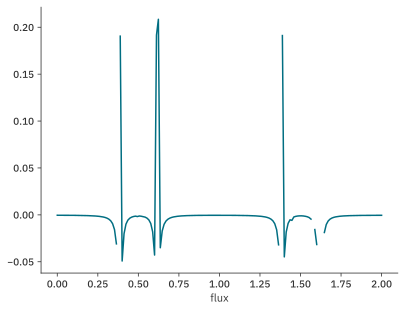

In [3]:
sweep["chi"]["subsys1":0, "subsys2":2]["ng":0][:, 1].plot()

(Interruptions again mark dispersive-limit breakdown. The unattractive "spikes" actually correspond to capturing part of the transmon's straddling regime, close to the breakdown of perturbation theory.)

Inspection of the transition spectrum matches the positions of singular behavior in $\chi$ with avoided crossings:

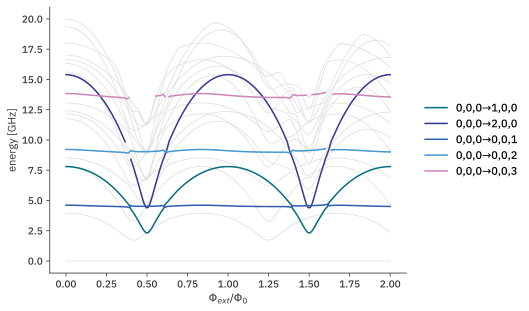

In [4]:
sweep["ng":0].plot_transitions(subsystems=[tmon1, resonator]);


.. note::
    Since dressed eigenenergies are used to compute these coefficients, results will not precisely agree with a 
    purely perturbative calculations stopping at finite order. For instance, the coefficients calculated here will
    not always show the divergences typical for the breakdown of perturbation theory at avoided crossings. 

#### Theoretical background, definition of dispersive quantities
Consider a system of harmonic modes ($s=0,1,\ldots$) and qubit modes ($q=0,1,\ldots$) coupled to each other,
 
**Hamiltonian**
\begin{equation}
H = \sum_s \omega_s a_s^\dagger a_s + \sum_{q,l} \epsilon^q_l |l_q\rangle\langle l_q| 
+ \sum_{s\not=s'} g^{ss'}(a_s + a_s^\dagger)(a_{s'} + a_{s'}^\dagger)
+ \sum_{s,q,l} g^{sq}_{ll'} (a_s + a_s^\dagger)|l_q\rangle\langle l_q'|
+ \sum_{q\not=q'}\sum_{lm,l'm'}g^{qq'}_{lm,l'm'}|l_q l'_{q'}\rangle\langle m_q m'_{q'}|
\end{equation}

  
If this system is fully dispersive, then the leading terms in the effective Hamiltonian, as obtained by a Schrieffer-Wolff transformation, can be written as:<br>

**Dispersive Hamiltonian**
\begin{align}
H_\text{eff}&= E_0 + \underbrace{\sum_s (\omega_s + \Delta\omega_s) a_s^\dagger a_s + \sum_{q,l>0} (\bar{\epsilon}^q_l + \Delta \bar{\epsilon}^q_l)|l_q\rangle\langle l_q|}_\text{bare modes plus Lamb shifts}
+\underbrace{\sum_{s;q,l>0}\bar{\chi}^{sq}_l a_s^\dagger a_s |l_q\rangle\langle l_q|}_\text{ac Stark shifts}
+\underbrace{\sum_{s> s'} K_{ss'}   a_s^\dagger a_s a_{s'}^\dagger  a_{s'}}_\text{cross-Kerr}\\
&\quad +\underbrace{\sum_{s} K_{s}   a_s^\dagger  a_{s}^\dagger  a_{s} a_{s}}_\text{self-Kerr}
+\underbrace{\sum_{ql \not= q'l'} \Lambda^{qq'}_{ll'} |l_q,l'_{q'}\rangle \langle l_q, l'_{q'}|}_\text{interaction among anharmonic modes}
\end{align}

Here, the energy coefficients are:
\begin{align}
&E_0 =\textstyle \sum_q \epsilon^q_0 && \text{(global energy offset)}\\
&\Delta\omega_s && \text{(harmonic mode frequency corrections)}\\
&\bar{\epsilon}^q_l = \epsilon^q_l - \epsilon^q && \text{(anharmonic mode energies relative to respective ground state energy)}\\
&\Delta\bar{\epsilon}^q_l && \text{(Lamb shifts)}\\
&\bar{\chi}^{sq}_l = \chi^{sq}_l - \chi^{sq}_0 && \text{(ac Stark shift for modes $s$ and $q$, relative to the $q=0$ state)}\\
&K_{ss'}, K_s && \text{(cross- and self-Kerr)}\\
&\Lambda^{qq'}_{ll'} && \text{("Kerr" among qubit modes)}
\end{align}

#### Evaluation of energy coefficients
The various energy coefficients are evaluated by forming appropriate energy differences of the dressed eigenenergies. Denote the latter as

\begin{equation} E(n_1,n_2,\ldots;l_1,l_2,\ldots) = E(\vec{n},\vec{l})\end{equation}

With this the dispersive energy coefficients are:

**Lamb shift, anharmonic mode**<br>
$\Delta\bar{\epsilon}^q_l = E(\vec{o},l\hat{e}_q) - E(\vec{o},\vec{o}) - \bar{\epsilon}^q_l$ 

**Lamb shift, harmonic mode**<br>
$\Delta\omega_s = E(\hat{e}_s,\vec{o}) - E(\vec{o},\vec{o}) - \omega_s$ 

**AC Stark shift**<br>
$\bar{\chi}^{sq}_l = E(\hat{e}_s,l\hat{e}_q) -(\epsilon^q_l + \Delta\epsilon^q_l) - (\omega_s + \Delta\omega_s) - E(\vec{o},\vec{o})$

**self-Kerr**<br>
$K_{s} = [E(2\hat{e}_s,\vec{o}) - E(\vec{o},\vec{o}) - 2(\omega_s + \Delta\omega_s)]/2$

**cross-Kerr**<br>
$K_{ss'} = E(\hat{e}_s + \hat{e}_{s'}) - E(\vec{o},\vec{o}) - (\omega_s + \Delta\omega_s) - (\omega_{s'} + \Delta\omega_{s'})\qquad (s\not=s')$

**anharmonic "Kerr"**<br>
$\Lambda^{qq'}_{ll'} = E(\vec{o}, l\hat{e}_q + l'\hat{e}_{q'},\vec{o}) - E(\vec{o},\vec{o}) - (\bar{\epsilon}^q_l + \Delta\bar{\epsilon}^q_l) - (\bar{\epsilon}^{q'}_{l'} + \Delta\bar{\epsilon}^{q'}_{l'})\qquad (s\not=s')$


For the sake of numerics, we unify the treatment and temporarily treat all modes as anharmonic, on equal footing:

**generalized Lamb shift**<br>
$\Delta\bar{\Omega}^r_l = E(l\hat{e}_r) - E(\vec{o}) - (\Omega^r_l - \Omega^r_0)$ <br>
Obtain $\Delta\omega_a$ by choosing $r$ to be an oscillator subsystem and set $l=1$.<br>
Obtain $\Delta\bar{\epsilon}^q_l$ by choosing $r$ to be a qubit subsystem.

**generalized Kerr/Stark**<br>
$\Xi^{rr'}_{ll'} = E(l\hat{e}_r + l'\hat{e}_{r'})- E(\vec{o}) - [E(l\hat{e}_r) - E(\vec{o})] - [E(l'\hat{e}_{r'}) - E(\vec{o})] = E(l\hat{e}_r + l'\hat{e}_{r'})+ E(\vec{o}) - E(l\hat{e}_r) - E(l'\hat{e}_{r'}) $<br>
Obtain the AC Stark shift $\bar{\chi}^{sq}_l$ by choosing $r=q$ (anh. mode), $r'=s$ (osc.) and $l'=1$.<br>
Obtain self- and cross-Kerr by choosing $r,r'$ from the oscillator subsystems and $l=l'=1$.<br>
Obtain the "anharmonic Kerr" by choosing $r,r'$ from the qubit subsystems.